In [1]:
# load from csv files

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from extract import extract
from crop import crop

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read in the train and test data and lables :
train_data = pd.read_csv('./data_csv/train-extracted.csv')
train_lables = pd.read_csv('./data_csv/train-lables.csv')
test_data = pd.read_csv('./data_csv/test-extracted.csv')
test_lables = pd.read_csv('./data_csv/test-lables.csv')

# sheck :
print(train_data.shape[0]+1)
print(test_data.shape[0]+1)

59999
9999


In [4]:
# drop not needed cols :
train_data = train_data.drop("Unnamed: 0",axis=1)
test_data = test_data.drop("Unnamed: 0",axis=1)
train_lables = train_lables.drop("Unnamed: 0",axis=1)
test_lables = test_lables.drop("Unnamed: 0",axis=1)

In [5]:
# putting lables and data in place :
train_y = train_lables.values[:,0]
train_x = train_data.values.astype(np.float32)
test_y = test_lables.values[:,0]
test_x = test_data.values.astype(np.float32)

In [6]:
# shape of lables :
print(train_y)

[0 4 1 ... 5 6 8]


In [7]:
# Calculate how much of our training data is for train and validation.
VALIDATION_PERCENT = 0.1
num_train = len(train_y)
num_val = int(num_train*VALIDATION_PERCENT)

In [8]:
# Split for train/val.
val_x = train_x[0:num_val]
val_y = train_y[0:num_val]
train_x = train_x[num_val:]
train_y = train_y[num_val:]

In [9]:
print(train_y.shape)

(54000,)


In [10]:
# creating the dataset
class MnistDataset(Dataset):
    
    def __init__(self, x, y=None):
        self.data = x
        self.labels = y
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.data[idx], self.labels[idx]
        else:
            return self.data[idx]

In [11]:
# loaders :
train_dataset = MnistDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)

test_dataset = MnistDataset(test_x,test_y)
test_loader = DataLoader(train_dataset,batch_size=30,shuffle=True)

validation_dataset = MnistDataset(val_x, val_y)
validation_loader = DataLoader(validation_dataset, batch_size=30, shuffle=False)

In [12]:
# creating the modele
input_size = 32
hidden_sizes = [100,70,25]
output_size = 10
model = nn.Sequential(nn.Conv2d(input_size, hidden_sizes[0],kernel_size=3),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),nn.LogSoftmax(dim=1)
                     )


36680

In [14]:
# creating the class :
class myNN(nn.Module):
    def __init__(self):
        super(myNN, self).__init__()
        self.fc1 = nn.Linear(32, 100) 
        self.fc2 = nn.Linear(100, 70)
        self.fc3 = nn.Linear(70, 25)
        self.fc4 = nn.Linear(25,10)
    def forward(self, x):
            x = x.view(-1,32)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x


In [15]:
# Model object:
myModel=myNN()

12405

In [17]:
# la fonction du coût
loss=nn.CrossEntropyLoss()

In [18]:
# fonction d'optimisation des coût: Adam par exemple.
opt = optim.Adam(myModel.parameters(), lr=0.001)

In [19]:
# le nombre d'epochs. 
n_epochs = 100


In [20]:
from torch.autograd import Variable

for epoch in range(n_epochs):
    myModel.train()
    t_cost= 0.0
    for i,(inputs,labels) in enumerate(train_loader):
        inputs = inputs.float()
        labels = labels.float()
        outputs = myModel(inputs)
        cout = loss(outputs,labels.long())
        # Backpropagation: 
        # Réinitialiser l'optimiseur
        opt.zero_grad()
        # Faire la backpropagation
        cout.backward()
        # Effectuer un pas d'optimisation
        opt.step()
        # Mettre à jour votre coût d'apprentissage en lui ajoutant le coût du data batch
        t_cost += cout
    # A la sortie de la boucle de l'entraînement, on calcule le coût moyen pour toutes les données training
    t_cout_moy = t_cost/(len(train_loader))
    v_cost= 0.0
    n_prev = 0
    # mode d'évaluation
    myModel.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        total_losss =0

        for i, data in enumerate(validation_loader):    

            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            outputs = myModel(inputs)

            cout = loss(outputs,labels.long())

            v_cost += cout
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
 
        v_cout_moy = v_cost/(len(train_loader))
        accuracy = correct / total
    # show stuff :
    print("epoche:",epoch)
    print("coût d'entraînement :",t_cout_moy)
    print("coût de validation :",v_cout_moy)
    print("précision :",accuracy)
    print('------------')
        
        

epoche: 0
coût d'entraînement : tensor(1.1383, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0980)
précision : 0.711285214202367
------------
epoche: 1
coût d'entraînement : tensor(0.8656, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0858)
précision : 0.744957492915486
------------
epoche: 2
coût d'entraînement : tensor(0.7836, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0818)
précision : 0.7562927154525755
------------
epoche: 3
coût d'entraînement : tensor(0.7320, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0770)
précision : 0.7701283547257877
------------
epoche: 4
coût d'entraînement : tensor(0.6964, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0738)
précision : 0.776129354892482
------------
epoche: 5
coût d'entraînement : tensor(0.6698, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0722)
précision : 0.785964327387898
------------
epoche: 6
coût d'entraînement : tensor(0.6477, grad_fn=<DivBackward0>)
coût de validation : tensor

epoche: 55
coût d'entraînement : tensor(0.4481, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0727)
précision : 0.7997999666611102
------------
epoche: 56
coût d'entraînement : tensor(0.4443, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0733)
précision : 0.8004667444574096
------------
epoche: 57
coût d'entraînement : tensor(0.4447, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0734)
précision : 0.8018003000500084
------------
epoche: 58
coût d'entraînement : tensor(0.4453, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0723)
précision : 0.7996332722120353
------------
epoche: 59
coût d'entraînement : tensor(0.4423, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0725)
précision : 0.8029671611935323
------------
epoche: 60
coût d'entraînement : tensor(0.4415, grad_fn=<DivBackward0>)
coût de validation : tensor(0.0722)
précision : 0.8036339389898316
------------
epoche: 61
coût d'entraînement : tensor(0.4409, grad_fn=<DivBackward0>)
coût de validati

In [21]:
# testing:

In [22]:

c_test = 0.0
n_prev_c = 0

with torch.no_grad():        
    for i,(inputs,labels) in enumerate(test_loader):        
            inputs, labels = data
            inputs = inputs.float()
            labels = labels.float()
            outputs = myModel(inputs)
            cout = loss(outputs,labels.long())
            c_test+=cout
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item() 
    c_test_moy = c_test/len(train_loader)
        
        
    # Calculer la précision pour test
    n_prev_cmoy = correct/total
    print(n_prev_cmoy)



0.9175415385144075


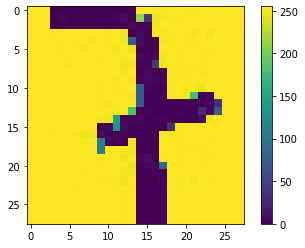

[[ -6.6845126 -10.578866    0.5018872  -1.2723503  -2.659951   -4.635231
  -18.11028     5.5178003  -1.963344    1.1133583 -46.246838  -46.459198
  -44.594738  -45.365467  -45.40426   -44.967503  -45.01489   -47.028625
  -46.33198   -46.332596  -45.311314  -46.442867  -46.054955  -46.19259
  -45.620045 ]]
7


In [31]:
# testing the model on a canvas from the gui :

my_img = cv2.imread('./image.jpg',0)
my_img = crop(my_img)
plt.imshow(my_img)
plt.colorbar()
plt.show()
 
val = extract(my_img)
hehe = myModel(torch.FloatTensor(val))

print(hehe.data.max(1, keepdim=True)[1].item())

In [24]:
# showing some test results :
for i in range(100,120):
    out = myModel(torch.FloatTensor(test_x[i]))
    print("lable:",test_y[i])
    print("prediction:",out.data.max(1, keepdim=True)[1].item())

lable: 0
prediction: 0
lable: 5
prediction: 5
lable: 4
prediction: 2
lable: 9
prediction: 9
lable: 9
prediction: 9
lable: 2
prediction: 2
lable: 1
prediction: 1
lable: 9
prediction: 9
lable: 4
prediction: 4
lable: 8
prediction: 8
lable: 7
prediction: 7
lable: 3
prediction: 5
lable: 9
prediction: 9
lable: 7
prediction: 7
lable: 4
prediction: 7
lable: 4
prediction: 9
lable: 4
prediction: 4
lable: 9
prediction: 8
lable: 2
prediction: 5
lable: 5
prediction: 5


In [30]:
# finally saving the modle to use it later

In [32]:
#torch.save(myModel.state_dict(),'./model-80-91')